In [1]:
import json
import os
from abc import abstractmethod
from glob import glob

import numpy as np
import soundfile
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

In [2]:
SAMPLE_RATE = 16000
HOP_LENGTH = SAMPLE_RATE * 32 // 1000
ONSET_LENGTH = SAMPLE_RATE * 32 // 1000
OFFSET_LENGTH = SAMPLE_RATE * 32 // 1000
HOPS_IN_ONSET = ONSET_LENGTH // HOP_LENGTH
HOPS_IN_OFFSET = OFFSET_LENGTH // HOP_LENGTH
MIN_MIDI = 21
MAX_MIDI = 108

N_MELS = 229
MEL_FMIN = 30
MEL_FMAX = SAMPLE_RATE // 2
WINDOW_LENGTH = 2048

DEFAULT_DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import multiprocessing
import sys

import mido
import numpy as np
from joblib import Parallel, delayed
from mido import Message, MidiFile, MidiTrack
from mir_eval.util import hz_to_midi
from tqdm import tqdm


def parse_midi(path):
    """open midi file and return np.array of (onset, offset, note, velocity) rows"""
    midi = mido.MidiFile(path)

    time = 0
    sustain = False
    events = []
    for message in midi:
        time += message.time

        if message.type == 'control_change' and message.control == 64 and (message.value >= 64) != sustain:
            # sustain pedal state has just changed
            sustain = message.value >= 64
            event_type = 'sustain_on' if sustain else 'sustain_off'
            event = dict(index=len(events), time=time, type=event_type, note=None, velocity=0)
            events.append(event)

        if 'note' in message.type:
            # MIDI offsets can be either 'note_off' events or 'note_on' with zero velocity
            velocity = message.velocity if message.type == 'note_on' else 0
            event = dict(index=len(events), time=time, type='note', note=message.note, velocity=velocity, sustain=sustain)
            events.append(event)

    notes = []
    for i, onset in enumerate(events):
        if onset['velocity'] == 0:
            continue

        # find the next note_off message
        offset = next(n for n in events[i + 1:] if n['note'] == onset['note'] or n is events[-1])

        if offset['sustain'] and offset is not events[-1]:
            # if the sustain pedal is active at offset, find when the sustain ends
            offset = next(n for n in events[offset['index'] + 1:] if n['type'] == 'sustain_off' or n is events[-1])

        note = (onset['time'], offset['time'], onset['note'], onset['velocity'])
        notes.append(note)

    return np.array(notes)


def save_midi(path, pitches, intervals, velocities):
    """
    Save extracted notes as a MIDI file
    Parameters
    ----------
    path: the path to save the MIDI file
    pitches: np.ndarray of bin_indices
    intervals: list of (onset_index, offset_index)
    velocities: list of velocity values
    """
    file = MidiFile()
    track = MidiTrack()
    file.tracks.append(track)
    ticks_per_second = file.ticks_per_beat * 2.0

    events = []
    for i in range(len(pitches)):
        events.append(dict(type='on', pitch=pitches[i], time=intervals[i][0], velocity=velocities[i]))
        events.append(dict(type='off', pitch=pitches[i], time=intervals[i][1], velocity=velocities[i]))
    events.sort(key=lambda row: row['time'])

    last_tick = 0
    for event in events:
        current_tick = int(event['time'] * ticks_per_second)
        velocity = int(event['velocity'] * 127)
        if velocity > 127:
            velocity = 127
        pitch = int(round(hz_to_midi(event['pitch'])))
        track.append(Message('note_' + event['type'], note=pitch, velocity=velocity, time=current_tick - last_tick))
        last_tick = current_tick

    file.save(path)


if __name__ == '__main__':

    def process(input_file, output_file):
        midi_data = parse_midi(input_file)
        np.savetxt(output_file, midi_data, '%.6f', '\t', header='onset\toffset\tnote\tvelocity')


    def files():
        for input_file in tqdm(sys.argv[1:]):
            if input_file.endswith('.mid'):
                output_file = input_file[:-4] + '.tsv'
            elif input_file.endswith('.midi'):
                output_file = input_file[:-5] + '.tsv'
            else:
                print('ignoring non-MIDI file %s' % input_file, file=sys.stderr)
                continue

            yield (input_file, output_file)

    Parallel(n_jobs=multiprocessing.cpu_count())(delayed(process)(in_file, out_file) for in_file, out_file in files())


  0%|          | 0/2 [00:00<?, ?it/s]ignoring non-MIDI file -f
ignoring non-MIDI file /root/.local/share/jupyter/runtime/kernel-5646da25-b502-40d8-a409-11d01f076342.json
100%|██████████| 2/2 [00:00<00:00, 4126.22it/s]


In [4]:
class PianoRollAudioDataset(Dataset):
    def __init__(self, path, groups=None, sequence_length=None, seed=42, device=DEFAULT_DEVICE):
        self.path = path
        self.groups = groups if groups is not None else self.available_groups()
        self.sequence_length = sequence_length
        self.device = device
        self.random = np.random.RandomState(seed)

        self.data = []
        print(f"Loading {len(groups)} group{'s' if len(groups) > 1 else ''} "
              f"of {self.__class__.__name__} at {path}")
        for group in groups:
            for input_files in tqdm(self.files(group), desc='Loading group %s' % group): #self.files is defined in MAPS class
                self.data.append(self.load(*input_files)) # self.load is a function defined below. It first loads all data into memory first

    def __getitem__(self, index):
        data = self.data[index]
        result = dict(path=data['path'])

        if self.sequence_length is not None:
            audio_length = len(data['audio'])
            step_begin = self.random.randint(audio_length - self.sequence_length) // HOP_LENGTH
            n_steps = self.sequence_length // HOP_LENGTH
            step_end = step_begin + n_steps

            begin = step_begin * HOP_LENGTH
            end = begin + self.sequence_length

            result['audio'] = data['audio'][begin:end].to(self.device)
            result['label'] = data['label'][step_begin:step_end, :].to(self.device)
            result['velocity'] = data['velocity'][step_begin:step_end, :].to(self.device)
        else:
            result['audio'] = data['audio'].to(self.device)
            result['label'] = data['label'].to(self.device)
            result['velocity'] = data['velocity'].to(self.device).float()

        result['audio'] = result['audio'].float().div_(32768.0) # converting to float by dividing it by 2^15
        result['onset'] = (result['label'] == 3).float()
        result['offset'] = (result['label'] == 1).float()
        result['frame'] = (result['label'] > 1).float()
        result['velocity'] = result['velocity'].float().div_(128.0)

        return result

    def __len__(self):
        return len(self.data)

    @classmethod # This one seems optional?
    @abstractmethod # This is to make sure other subclasses also contain this method
    def available_groups(cls):
        """return the names of all available groups"""
        raise NotImplementedError

    @abstractmethod
    def files(self, group):
        """return the list of input files (audio_filename, tsv_filename) for this group"""
        raise NotImplementedError

    def load(self, audio_path, tsv_path):
        """
        load an audio track and the corresponding labels

        Returns
        -------
            A dictionary containing the following data:

            path: str
                the path to the audio file

            audio: torch.ShortTensor, shape = [num_samples]
                the raw waveform

            label: torch.ByteTensor, shape = [num_steps, midi_bins]
                a matrix that contains the onset/offset/frame labels encoded as:
                3 = onset, 2 = frames after onset, 1 = offset, 0 = all else

            velocity: torch.ByteTensor, shape = [num_steps, midi_bins]
                a matrix that contains MIDI velocity values at the frame locations
        """
        saved_data_path = audio_path.replace('.flac', '.pt').replace('.wav', '.pt')
        if os.path.exists(saved_data_path): # Check if files exist, if so just load the files
            return torch.load(saved_data_path)

        audio, sr = soundfile.read(audio_path, dtype='int16')
        assert sr == SAMPLE_RATE

        audio = torch.ShortTensor(audio)
        audio_length = len(audio)

        n_keys = MAX_MIDI - MIN_MIDI + 1
        n_steps = (audio_length - 1) // HOP_LENGTH + 1

        label = torch.zeros(n_steps, n_keys, dtype=torch.uint8)
        velocity = torch.zeros(n_steps, n_keys, dtype=torch.uint8)

        tsv_path = tsv_path
        midi = np.loadtxt(tsv_path, delimiter='\t', skiprows=1)

        for onset, offset, note, vel in midi:
            left = int(round(onset * SAMPLE_RATE / HOP_LENGTH))
            onset_right = min(n_steps, left + HOPS_IN_ONSET)
            frame_right = int(round(offset * SAMPLE_RATE / HOP_LENGTH))
            frame_right = min(n_steps, frame_right)
            offset_right = min(n_steps, frame_right + HOPS_IN_OFFSET)

            f = int(note) - MIN_MIDI
            label[left:onset_right, f] = 3
            label[onset_right:frame_right, f] = 2
            label[frame_right:offset_right, f] = 1
            velocity[left:frame_right, f] = vel

        data = dict(path=audio_path, audio=audio, label=label, velocity=velocity)
        torch.save(data, saved_data_path)
        return data

In [5]:
class MAPS(PianoRollAudioDataset):
    def __init__(self, path='data/MAPS', groups=None, sequence_length=None, seed=42, device=DEFAULT_DEVICE):
        super().__init__(path, groups if groups is not None else ['ENSTDkAm', 'ENSTDkCl'], sequence_length, seed, device)

    @classmethod
    def available_groups(cls):
        return ['AkPnBcht', 'AkPnBsdf', 'AkPnCGdD', 'AkPnStgb', 'ENSTDkAm', 'ENSTDkCl', 'SptkBGAm', 'SptkBGCl', 'StbgTGd2']

    def files(self, group):
        flacs = glob(os.path.join(self.path, 'flac', '*_%s.flac' % group))
        tsvs = [f.replace('/flac/', '/tsv/matched/').replace('.flac', '.tsv') for f in flacs]

        assert(all(os.path.isfile(flac) for flac in flacs))
        assert(all(os.path.isfile(tsv) for tsv in tsvs))

        return sorted(zip(flacs, tsvs))

In [6]:
path = './data/MAPS'
group = 'AkPnBcht'

In [7]:
flacs = glob(os.path.join(path, 'flac', '*_%s.flac' % group))
tsvs = [f.replace('/flac/', '/tsv/matched/').replace('.flac', '.tsv') for f in flacs]

In [20]:
def load(audio_path, tsv_path):
    """
    load an audio track and the corresponding labels

    Returns
    -------
        A dictionary containing the following data:

        path: str
            the path to the audio file

        audio: torch.ShortTensor, shape = [num_samples]
            the raw waveform

        label: torch.ByteTensor, shape = [num_steps, midi_bins]
            a matrix that contains the onset/offset/frame labels encoded as:
            3 = onset, 2 = frames after onset, 1 = offset, 0 = all else

        velocity: torch.ByteTensor, shape = [num_steps, midi_bins]
            a matrix that contains MIDI velocity values at the frame locations
    """
    saved_data_path = audio_path.replace('.flac', '.pt').replace('.wav', '.pt')
    if os.path.exists(saved_data_path): # Check if files exist, if so just load the files
        # This .pt file contains  
        return torch.load(saved_data_path)

    # If the pytorch version of the audio doesn't exist, make it here
    audio, sr = soundfile.read(audio_path, dtype='int16')
    assert sr == SAMPLE_RATE

    audio = torch.ShortTensor(audio)
    audio_length = len(audio)
    print(f'audio_length = {audio_length}')

    n_keys = MAX_MIDI - MIN_MIDI + 1
    n_steps = (audio_length - 1) // HOP_LENGTH + 1

    label = torch.zeros(n_steps, n_keys, dtype=torch.uint8)
    velocity = torch.zeros(n_steps, n_keys, dtype=torch.uint8)

    tsv_path = tsv_path
    midi = np.loadtxt(tsv_path, delimiter='\t', skiprows=1)

    for onset, offset, note, vel in midi:
        left = int(round(onset * SAMPLE_RATE / HOP_LENGTH))
        onset_right = min(n_steps, left + HOPS_IN_ONSET)
        frame_right = int(round(offset * SAMPLE_RATE / HOP_LENGTH))
        frame_right = min(n_steps, frame_right)
        offset_right = min(n_steps, frame_right + HOPS_IN_OFFSET)

        f = int(note) - MIN_MIDI
        label[left:onset_right, f] = 3
        label[onset_right:frame_right, f] = 2
        label[frame_right:offset_right, f] = 1
        velocity[left:frame_right, f] = vel

    data = dict(path=audio_path, audio=audio, label=label, velocity=velocity)
    torch.save(data, saved_data_path)
    return data

In [21]:
data = []
for input_files in tqdm(sorted(zip(flacs, tsvs)), desc='Loading group %s' % group):
    data.append(load(*input_files))

Loading group AkPnBcht:   0%|          | 0/30 [00:00<?, ?it/s]

audio_length = 4001245


Loading group AkPnBcht:   7%|▋         | 2/30 [00:00<00:07,  3.51it/s]

audio_length = 3648938
audio_length = 3076092


Loading group AkPnBcht:  10%|█         | 3/30 [00:00<00:06,  3.87it/s]

audio_length = 6333250


Loading group AkPnBcht:  13%|█▎        | 4/30 [00:01<00:07,  3.47it/s]

audio_length = 8264879


Loading group AkPnBcht:  20%|██        | 6/30 [00:01<00:07,  3.31it/s]

audio_length = 946111
audio_length = 2487763


Loading group AkPnBcht:  23%|██▎       | 7/30 [00:01<00:05,  4.09it/s]

audio_length = 474811
audio_length = 531483
audio_length = 2003501


Loading group AkPnBcht:  40%|████      | 12/30 [00:02<00:02,  6.39it/s]

audio_length = 858203
audio_length = 1668363
audio_length = 1458414


Loading group AkPnBcht:  47%|████▋     | 14/30 [00:02<00:02,  6.99it/s]

audio_length = 1460302
audio_length = 4401535


Loading group AkPnBcht:  53%|█████▎    | 16/30 [00:03<00:02,  4.97it/s]

audio_length = 4558052
audio_length = 2377947


Loading group AkPnBcht:  60%|██████    | 18/30 [00:03<00:01,  6.03it/s]

audio_length = 1767046
audio_length = 2488294


Loading group AkPnBcht:  63%|██████▎   | 19/30 [00:03<00:01,  5.58it/s]

audio_length = 6349888


Loading group AkPnBcht:  70%|███████   | 21/30 [00:03<00:01,  4.92it/s]

audio_length = 1639156
audio_length = 5882064


Loading group AkPnBcht:  73%|███████▎  | 22/30 [00:04<00:01,  4.29it/s]

audio_length = 11999525


Loading group AkPnBcht:  77%|███████▋  | 23/30 [00:04<00:02,  2.94it/s]

audio_length = 5662348


Loading group AkPnBcht:  83%|████████▎ | 25/30 [00:05<00:01,  2.95it/s]

audio_length = 5047215
audio_length = 541741


Loading group AkPnBcht:  90%|█████████ | 27/30 [00:05<00:00,  3.92it/s]

audio_length = 2092786
audio_length = 7077074


Loading group AkPnBcht:  97%|█████████▋| 29/30 [00:06<00:00,  4.13it/s]

audio_length = 1832770
audio_length = 3104748


Loading group AkPnBcht: 100%|██████████| 30/30 [00:06<00:00,  4.79it/s]


In [22]:
from nnAudio import Spectrogram

In [35]:
audio, sr = soundfile.read(input_files[0], dtype='int16')
assert sr == SAMPLE_RATE

audio = torch.ShortTensor(audio)
audio_length = len(audio)

In [121]:
audio_list = []
for i in flacs:
    audio, sr = soundfile.read(i, dtype='int16')
    audio_list.append(audio.shape[0])

In [123]:
min(audio_list)

474811

In [36]:
n_keys = MAX_MIDI - MIN_MIDI + 1
n_steps = (audio_length - 1) // HOP_LENGTH + 1

In [39]:
label = torch.zeros(n_steps, n_keys, dtype=torch.uint8)
velocity = torch.zeros(n_steps, n_keys, dtype=torch.uint8)

In [40]:
midi = np.loadtxt(input_files[1], delimiter='\t', skiprows=1)

In [45]:
midi

array([[  0.529173,   1.935725,  50.      ,  33.      ],
       [  0.59352 ,   1.935725,  57.      ,  37.      ],
       [  0.65505 ,   1.842585,  62.      ,  40.      ],
       ...,
       [188.682262, 192.046746,  55.      ,  24.      ],
       [188.682262, 192.046746,  59.      ,  25.      ],
       [188.682262, 192.046746,  50.      ,  21.      ]])

In [43]:
onset, offset, note, vel = next(iter(midi))

In [50]:
left = int(round(onset * SAMPLE_RATE / HOP_LENGTH))
onset_right = min(n_steps, left + HOPS_IN_ONSET) # Ensure the time step of onset would not exceed the last time step
frame_right = int(round(offset * SAMPLE_RATE / HOP_LENGTH))
frame_right = min(n_steps, frame_right) # Ensure the time step of frame would not exceed the last time step
offset_right = min(n_steps, frame_right + HOPS_IN_OFFSET)

In [54]:
f = int(note) - MIN_MIDI

In [55]:
label[left:onset_right, f] = 3

In [58]:
import matplotlib.pyplot as plt

In [69]:
label.shape

torch.Size([6064, 88])

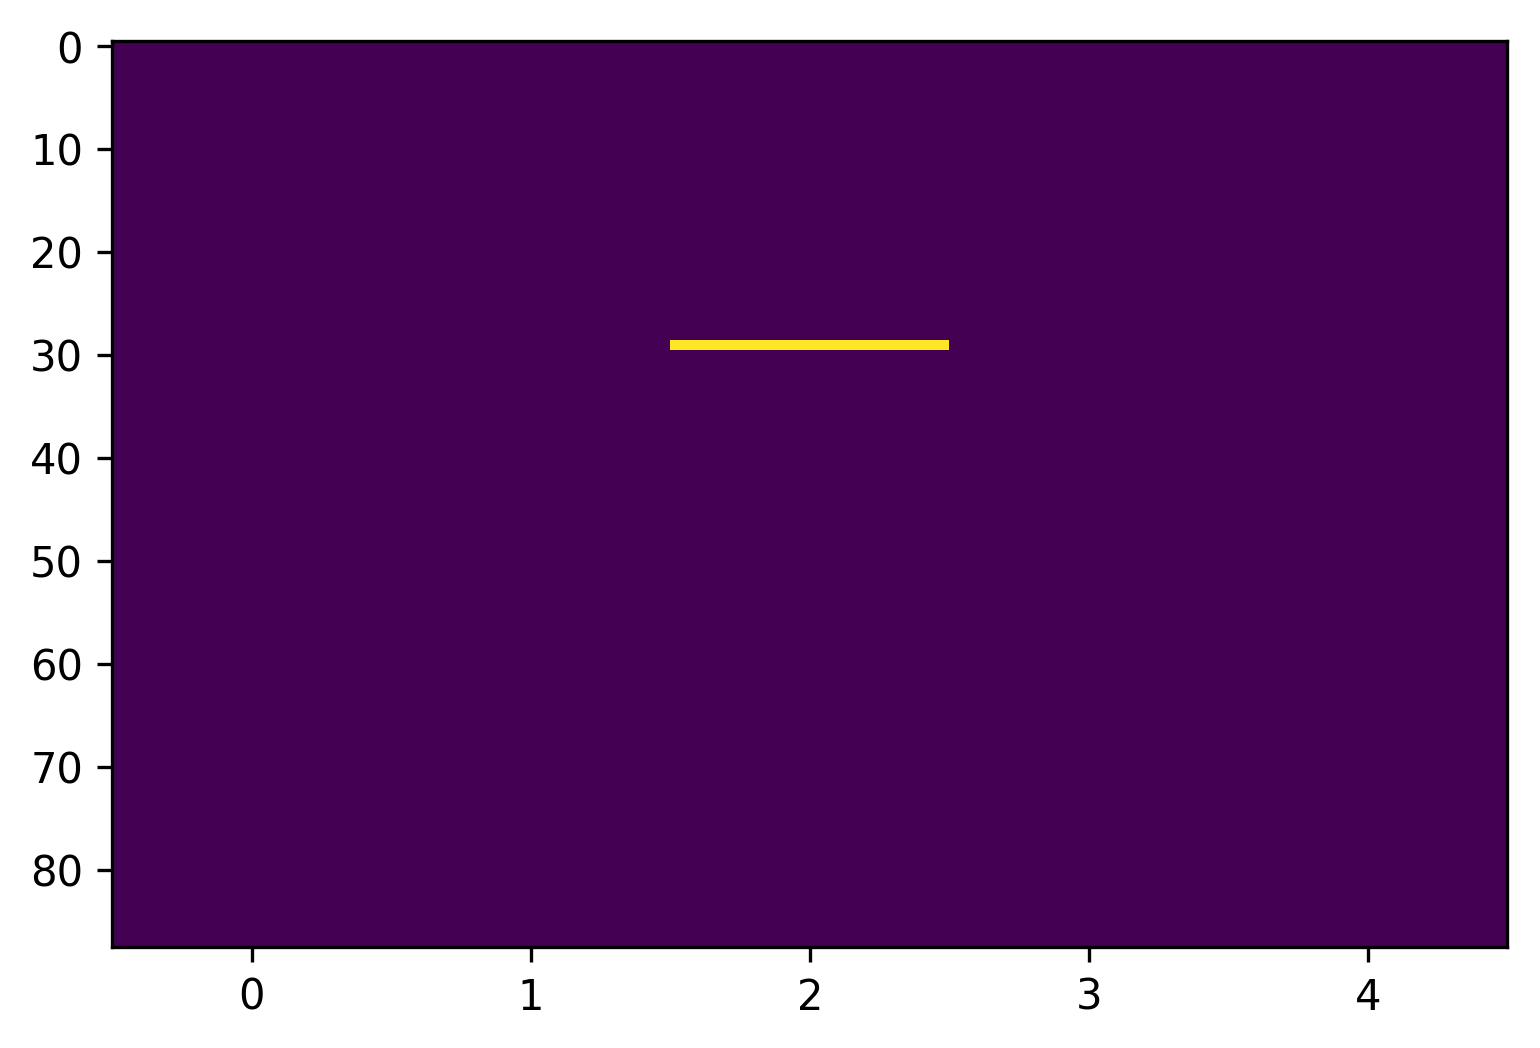

In [70]:
plt.figure(dpi=300)
plt.imshow(label[15:20].T, aspect='auto')

In [75]:
from sacred import Experiment
from sacred.commands import print_config, save_config
from sacred.observers import FileStorageObserver

In [76]:
ex = Experiment('train_transcriber')

RuntimeError: Defining an experiment in interactive mode! The sourcecode cannot be stored and the experiment won't be reproducible. If you still want to run it pass interactive=True

In [100]:
import pickle

In [88]:
ex = Experiment('train_transcriber', interactive=True)

In [89]:
@ex.config
def config():
    logdir = 'runs/TCN_bi7-' + datetime.now().strftime('%y%m%d-%H%M%S')
    device = f'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
save_config()

In [99]:
dict(config())

{'logdir': 'runs/TCN_bi7-200114-112539', 'device': 'cuda'}

In [109]:
def save_dict(obj, name ):
    with open('./runs/config/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [110]:
save_dict(config(), basename(logdir))

In [112]:
def load_obj(name):
    with open('./runs/config/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [113]:
load_obj('TCN_bi7-200114-111404')

{'logdir': 'runs/TCN_bi7-200114-113021', 'device': 'cuda'}

In [143]:
mel = Spectrogram.MelSpectrogram(sr, n_fft=1024, hop_length=HOP_LENGTH)

STFT filter created, time used = 0.0877 seconds
Mel filter created, time used = 0.0035 seconds


In [159]:
x = torch.randn(474811-512).cuda()

In [160]:
mel(x).shape

torch.Size([1, 128, 927])

In [148]:
HOP_LENGTH = SAMPLE_RATE * 32 // 1000

In [149]:
HOP_LENGTH

512

In [150]:
474811//HOP_LENGTH

927